Analisi tramite kernel quantistico del dataset sull'alzhaimer, per velocità di esecuzione la simulazione viene effettuata su un subset del campione e una ulteriore riduzione di Dim. passando da 21 a 14 features

In [1]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
from ZZFeatureSimulation import ZZFeatureSimulation
import pandas as pd
import numpy as np



df = pd.read_csv('quantum-alz.csv', sep=";", decimal=',')

X = df[['Cope_Avoidant', 'Cope_Active', 'BDI', 'SES', 'EHI', 'NEO_CON', 'NEO_AGR', 'AUDIT', 'Cope_Emotional', 'CVLT_9', 'N_CVLT_1', 'N_CVLT_2', 'Dim_1', 'Dim_4']]
Y = df[['Cluster']]

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.6, random_state=42)

In [2]:
X.head()
X.describe()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cope_Avoidant   76 non-null     float64
 1   Cope_Active     76 non-null     float64
 2   BDI             76 non-null     int64  
 3   SES             76 non-null     int64  
 4   EHI             76 non-null     float64
 5   NEO_CON         76 non-null     int64  
 6   NEO_AGR         76 non-null     int64  
 7   AUDIT           76 non-null     int64  
 8   Cope_Emotional  76 non-null     float64
 9   CVLT_9          76 non-null     int64  
 10  N_CVLT_1        76 non-null     float64
 11  N_CVLT_2        76 non-null     float64
 12  Dim_1           76 non-null     float64
 13  Dim_4           76 non-null     float64
dtypes: float64(8), int64(6)
memory usage: 8.4 KB


Applicazione di un encoding tramite zzfeaturemap di ogni singola feature nello spazio di hilbert, su una sfera di bloch, normalizzando i dati su angoli di rotazione sulla sfera, partiamo con un valore di rotazione di massimo pi/2 (90 gradi)

In [3]:
pi_half_simulation = ZZFeatureSimulation(x_train, np.pi/2)
pi_half_simulation.plot_kernel_matrix()

Inizio calcolo Kernel Quantistico per 45 pazienti.
Calcolando solo la metà superiore della matrice per simmetria...


Avanzamento:   0%|          | 0/45 [00:13<?, ?it/s]


KeyboardInterrupt: 

Il risultato di correlazione ottenuto dal Kernel quantistico usando l'approccio Fidelity quantum kernel con la scala di pi/2 non coglie abbastanza le relazioni, quindi abbassiamo fino a 0.5

In [ ]:
#pi_quarter_simulation = ZZFeatureSimulation(x_train, np.pi/4)
#pi_quarter_simulation.plot_kernel_matrix()

In [ ]:
half_range_simulation = ZZFeatureSimulation(x_train, 0.5)
half_range_simulation.plot_kernel_matrix()

Ottenuta una correlazione massima (escludendo gli outliers) del 30% costruiamo dei cluster, preferendo un numero di cluster uguale a 3 per il compare con il lavoro classico, previo controllo tramite elbow quantistico e metrica di Silhouette

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

kernel_matrix = half_range_simulation.get_kernel_matrix()
eigenvals, _ = np.linalg.eigh(kernel_matrix)
# Ordiniamo in modo decrescente (dal più grande al più piccolo)
eigenvals = np.sort(eigenvals)[::-1]

# Calcoliamo i "gap" (differenza tra un autovalore e il successivo)
gaps = np.diff(eigenvals) # Nota: sarà negativo, ne prendiamo il valore assoluto
gaps = np.abs(gaps)

# --- METODO B: SILHOUETTE SCORE ---
# Per la silhouette serve una DISTANZA, non una somiglianza.
# Convertiamo il Kernel in Distanza: D^2 = 2(1 - K) per kernel di fedeltà
quantum_distance_matrix = np.sqrt(2 * (1 - kernel_matrix))
# Rimuoviamo eventuali NaN dovuti a errori di virgola mobile
quantum_distance_matrix = np.nan_to_num(quantum_distance_matrix)

sil_scores = []
k_range = range(2, 5) # Proviamo da 2 a 9 cluster

for k in k_range:
    # Eseguiamo il clustering per questo k
    sc = SpectralClustering(n_clusters=k, affinity='precomputed', random_state=42)
    labels = sc.fit_predict(kernel_matrix) # Nota: al fit passiamo il KERNEL

    # Calcoliamo la silhouette usando la DISTANZA
    score = silhouette_score(quantum_distance_matrix, labels, metric='precomputed')
    sil_scores.append(score)

# --- PLOT DEI RISULTATI ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Eigengap
ax1.plot(range(1, 15), eigenvals[:14], 'o-', color='blue')
ax1.set_title("1. Analisi Autovalori (Eigengap)")
ax1.set_xlabel("Indice Autovalore")
ax1.set_ylabel("Valore")
ax1.grid(True)
ax1.annotate('Cerca il "Gomito" o il salto grande', xy=(3, eigenvals[2]), xytext=(5, eigenvals[0]),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Plot Silhouette
ax2.plot(k_range, sil_scores, 'o-', color='red')
ax2.set_title("2. Silhouette Score (Più alto è meglio)")
ax2.set_xlabel("Numero di Cluster (k)")
ax2.set_ylabel("Score")
ax2.grid(True)

plt.show()

costruzione e plot del cluster ottenuto

In [ ]:
from sklearn.decomposition import KernelPCA

# 1. numerod i cluster
k_best = 3

# 2. costruzione del cluster
model = SpectralClustering(n_clusters=k_best, affinity='precomputed', random_state=42)
labels = model.fit_predict(kernel_matrix)

# 3. Proietta in 2D usando Kernel PCA (che usa la tua matrice!)
kpca = KernelPCA(n_components=2, kernel='precomputed')
X_kpca = kpca.fit_transform(kernel_matrix)

# 4. Plot Finale
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=labels, cmap='viridis', s=100, edgecolor='k', alpha=0.8)

# Aggiungiamo i centroidi (media dei punti nel plot) per chiarezza
import pandas as pd
df_plot = pd.DataFrame(X_kpca, columns=['Dim1', 'Dim2'])
df_plot['Cluster'] = labels
centroids = df_plot.groupby('Cluster').mean()
plt.scatter(centroids['Dim1'], centroids['Dim2'], c='red', marker='X', s=200, label='Centroidi')

plt.title(f"Clustering Quantistico con k={k_best}")
plt.xlabel("Componente Principale Quantistica 1")
plt.ylabel("Componente Principale Quantistica 2")
plt.legend()
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, alpha=0.3)
plt.show()

Possiamo ora confrontare i due cluster tramite il metodo adjusted_rand_score che ci permettere di confrontare i due cluster con kmeans e l'approccio quantistico; Un valore di ari vicino a 1 significa che non ci sono differenze, prossimo allo 0 che le somiglianze sono casuali, minore di 0 sono totalmente in disaccordo

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Supponiamo tu abbia le due liste di etichette
labels_std = y_train['Cluster']
# labels_quant = df['Cluster_Quantum']

# 1. Adjusted Rand Index (Il "Voto" alla somiglianza)
ari = adjusted_rand_score(y_train['Cluster'], labels)

# 2. Normalized Mutual Information (Quanto uno spiega l'altro)
nmi = normalized_mutual_info_score(labels_std, labels)

print(f"Somiglianza dei Raggruppamenti (ARI): {ari:.3f}")
print(f"Informazione Condivisa (NMI): {nmi:.3f}")

Matrice di confusione per comprarare i due cluster

In [ ]:
crosstab = pd.crosstab(labels_std, labels,
                       rownames=['Standard (K-Means)'],
                       colnames=['Quantistico (Spectral)'])

# Visualizziamola come Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confronto: Dove sono finiti i pazienti?")
plt.show()

Grafico a barre sovrapposte per identificare meglio l'associazione fra i due cluster

In [ ]:
crosstab_norm = pd.crosstab(labels_std, labels, normalize='index')

crosstab_norm.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title("Come il Clustering Quantistico ridistribuisce i Cluster Standard")
plt.xlabel("Cluster Standard (K-Means)")
plt.ylabel("Proporzione di Pazienti")
plt.legend(title="Cluster Quantistico", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

I risultati ottenuti tramite FQK potrebbero non essere convincenti, quindi come suggerito dal paper analizzato proviamo l'approccio basato dul Projected quantum kernel

C:\Users\enzo2\AppData\Local\Temp\ipykernel_17696\3644215691.py:11: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear')


Estrazione features quantistiche per 76 pazienti ...
Nuove feature estratte: (76, 14)


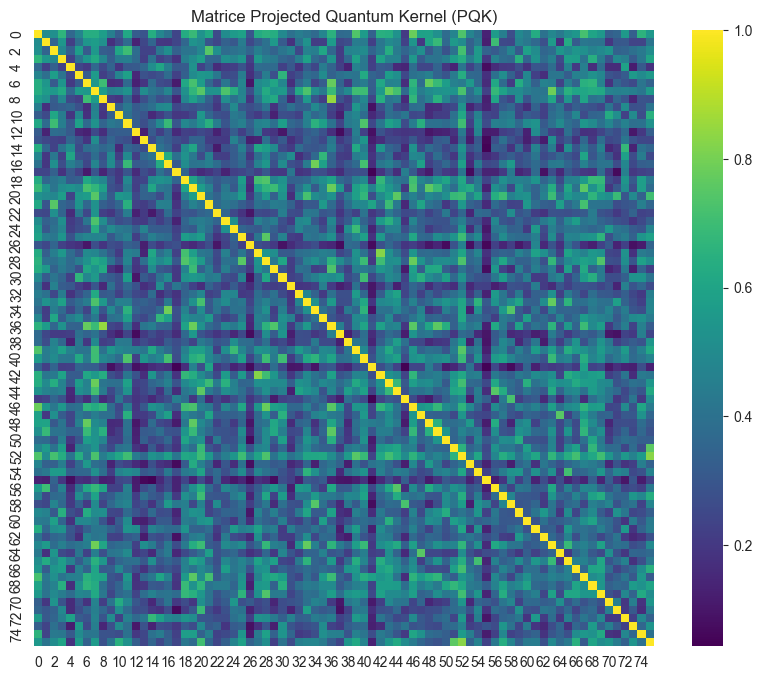

In [5]:
from scipy.spatial.distance import pdist
from sklearn.preprocessing import MinMaxScaler
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from sklearn.metrics.pairwise import rbf_kernel

# 1. Definisci il circuito

num_qubits = len(x_train.columns)
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear')

# 2. Definizione osservabili (Magnetizzazione Z su ogni qubit)
observables = [SparsePauliOp.from_list([("I" * i + "Z" + "I" * (num_qubits - 1 - i), 1)])
               for i in range(num_qubits)]

# 3.
def get_projected_features_v2(data, map, obs):
    # Usiamo StatevectorEstimator per simulazioni locali
    estimator = StatevectorEstimator()
    projected_data = []

    print(f"Estrazione features quantistiche per {len(data)} pazienti ...")

    for i, paziente in enumerate(data):
        # Assegna i parametri al circuito
        bound_circuit = map.assign_parameters(paziente)


        pub = (bound_circuit, obs)

        # Eseguiamo
        job = estimator.run([pub])

        # Il risultato si trova dentro .data.evs (Expectation Values)
        result = job.result()[0].data.evs

        projected_data.append(result)

    return np.array(projected_data)

# --- ESECUZIONE ---

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled_01 = scaler.fit_transform(X)

# Ora espandiamo al range quantistico [0, we]
quantum_scaled_data = X_scaled_01 * 2* np.pi
X_projected = get_projected_features_v2(quantum_scaled_data, feature_map, observables)

print("Nuove feature estratte:", X_projected.shape)
# Dovrebbe essere (75, 7) se hai 75 pazienti e 7 variabili

distanze_sq = pdist(X_projected, metric='sqeuclidean')

# 2. Trova la mediana delle distanze
mediana_dist = np.median(distanze_sq)

# 3. Calcola la Gamma Ottimale
# Formula: gamma = 1 / (mediana_distanze)
# Aggiungiamo un epsilon piccolo per evitare divisioni per zero se i punti sono identici
gamma_opt = 1.0 / (mediana_dist + 1e-10)
pqk_matrix = rbf_kernel(X_projected, gamma=gamma_opt)

# C. Visualizza
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(pqk_matrix, cmap='viridis')
plt.title("Matrice Projected Quantum Kernel (PQK)")
plt.show()

In [7]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import numpy as np

# Supponiamo che la tua matrice corretta si chiami 'pqk_matrix'
# Scegli il numero di cluster (es. 3, basandoti sulle tue analisi precedenti)
n_clusters = 3

# Configura lo Spectral Clustering
# affinity='precomputed' è FONDAMENTALE perché gli passi già la matrice kernel
spec_cluster = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',
    random_state=42,
    assign_labels='discretize' # Spesso più stabile di 'kmeans'
)

# Trova le etichette (0, 1, 2) per ogni paziente
labels_quantum = spec_cluster.fit_predict(pqk_matrix)

print(f"Clustering completato! Trovati {n_clusters} gruppi.")
print("Distribuzione pazienti:", np.bincount(labels_quantum))

# --- VERIFICA QUALITÀ (Silhouette Quantistica) ---
# Convertiamo la somiglianza in distanza: D = sqrt(2(1 - K))
# Nota: Poiché il PQK può avere valori > 1 sulla diagonale (non normalizzato perfettamente a 1),
# normalizziamo prima la matrice per avere 1 sulla diagonale.
d_diag = np.diag(pqk_matrix)
k_norm = pqk_matrix / np.sqrt(np.outer(d_diag, d_diag))

# Calcolo distanza quantistica
q_dist_matrix = np.sqrt(2 * (1 - k_norm))
q_dist_matrix = np.nan_to_num(q_dist_matrix) # Sicurezza numerica

sil_score = silhouette_score(q_dist_matrix, labels_quantum, metric='precomputed')
print(f"Silhouette Score (Qualità separazione): {sil_score:.3f}")

Clustering completato! Trovati 3 gruppi.
Distribuzione pazienti: [29 23 24]
Silhouette Score (Qualità separazione): 0.055


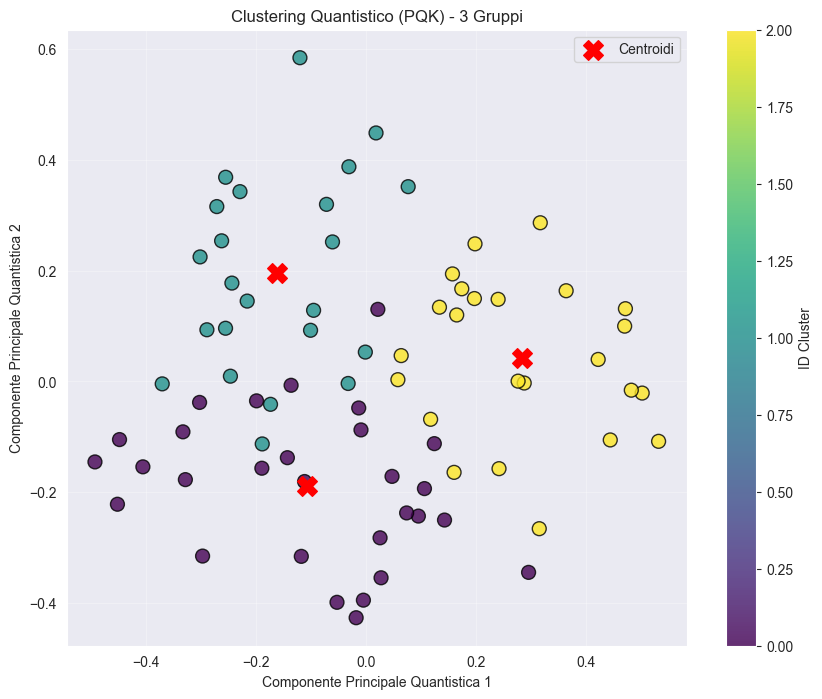

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
import pandas as pd

# 1. Proiezione 2D usando il Kernel Quantistico
kpca = KernelPCA(n_components=2, kernel='precomputed')
X_kpca = kpca.fit_transform(pqk_matrix)


# 2. Creiamo un DataFrame per facilitare il grafico
df_viz = pd.DataFrame(X_kpca, columns=['Dim1', 'Dim2'])
df_viz['Cluster'] = labels_quantum

# 3. Plot
plt.figure(figsize=(10, 8))

# Disegna i punti
scatter = plt.scatter(
    df_viz['Dim1'],
    df_viz['Dim2'],
    c=df_viz['Cluster'],
    cmap='viridis',
    s=100,
    edgecolor='k',
    alpha=0.8
)

# Aggiungi i centroidi (media visiva) per chiarezza
centroids = df_viz.groupby('Cluster').mean()
plt.scatter(centroids['Dim1'], centroids['Dim2'], c='red', marker='X', s=200, label='Centroidi')

# Estetica
plt.title(f"Clustering Quantistico (PQK) - {n_clusters} Gruppi")
plt.xlabel("Componente Principale Quantistica 1")
plt.ylabel("Componente Principale Quantistica 2")
plt.legend()
plt.colorbar(scatter, label='ID Cluster')
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Supponiamo tu abbia le due liste di etichette
labels_std = Y['Cluster']
# labels_quant = df['Cluster_Quantum']

# 1. Adjusted Rand Index (Il "Voto" alla somiglianza)
ari = adjusted_rand_score(Y['Cluster'], labels_quantum)

# 2. Normalized Mutual Information (Quanto uno spiega l'altro)
nmi = normalized_mutual_info_score(labels_std, labels_quantum)

print(f"Somiglianza dei Raggruppamenti (ARI): {ari:.3f}")
print(f"Informazione Condivisa (NMI): {nmi:.3f}")

Somiglianza dei Raggruppamenti (ARI): -0.011
Informazione Condivisa (NMI): 0.019


In [ ]:
crosstab_norm = pd.crosstab(labels_std, labels_quantum, normalize='index')

crosstab_norm.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title("Come il Clustering Quantistico ridistribuisce i Cluster Standard")
plt.xlabel("Cluster Standard (K-Means)")
plt.ylabel("Proporzione di Pazienti")
plt.legend(title="Cluster Quantistico", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [8]:
df_pqk = df.copy()
df_pqk['Cluster_PQK_simulated'] = labels_quantum
df_pqk.to_csv('df_pqk.csv', index=False)